In [1]:
%pip install ydata-profiling prince imbalanced-learn matplotlib scikit-learn joblib xgboost --upgrade


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import math
import time
import random
import datetime
import pandas as pd
import numpy as np
from ydata_profiling import ProfileReport
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn import model_selection, tree, preprocessing, metrics, linear_model
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron, SGDClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, learning_curve, cross_val_score
from xgboost import XGBClassifier
import warnings
import joblib
import os
warnings.filterwarnings('ignore')

In [3]:
# Check available Matplotlib styles
print("Available Matplotlib styles:", plt.style.available)
if 'seaborn-v0_8-whitegrid' not in plt.style.available:
    plt.style.use('classic')
    print("Using fallback style: 'classic' since 'seaborn-v0_8-whitegrid' is unavailable.")

Available Matplotlib styles: ['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'petroff10', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [6]:
# Load the dataset from public URL or local path
#url = 'https://raw.githubusercontent.com/JamieDuane/SC5010_IBM_Data_Analysis/main/data/WA_Fn-UseC_-HR-Employee-Attrition.csv'
try:
    #df = pd.read_csv(url)
    df = pd.read_csv(r"C:\Users\nehan\Downloads\Employee_Attrition_Prediction\WA_Fn-UseC_-HR-Employee-Attrition.csv")
    print("Original DataFrame shape:", df.shape)
    display(df.head())
except Exception as e:
    print(f"Error loading dataset: {e}")
    raise

Original DataFrame shape: (1470, 35)


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [7]:
# Generate Profiling Report
try:
    profile = ProfileReport(df, title="Employee Promotion Profiling Report", explorative=True)
    profile.to_file("promotion_report.html")
    print("Profiling report saved as 'promotion_report.html'")
except Exception as e:
    print(f"Error generating profiling report: {e}")
    raise

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 35/35 [00:00<00:00, 35.73it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Profiling report saved as 'promotion_report.html'


In [8]:
# Define target: 1 if recently promoted (YearsSinceLastPromotion == 0), 0 otherwise
try:
    y = (df['YearsSinceLastPromotion'] == 0).astype(int)
    print(f"Class distribution:\n{y.value_counts(normalize=True)}")  # Check balance
except KeyError as e:
    print(f"Error: 'YearsSinceLastPromotion' not found in DataFrame. {e}")
    raise

# Features: Drop only irrelevant/constant columns (keep YearsSinceLastPromotion, PercentSalaryHike for preprocessing)
drop_cols = ['EmployeeCount', 'StandardHours', 'Over18', 'EmployeeNumber']
try:
    X = df.drop(drop_cols, axis=1)
    print("X shape after dropping columns:", X.shape)  # Should be (1470, 31)
except Exception as e:
    print(f"Error dropping columns: {e}")
    raise

# Encode Attrition (since it's a feature)
try:
    le = LabelEncoder()
    X['Attrition'] = le.fit_transform(X['Attrition'])
except KeyError as e:
    print(f"Error encoding Attrition: {e}")
    raise

# Load or recreate preprocessor
numerical_cols = ['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EnvironmentSatisfaction', 'HourlyRate', 
                  'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 
                  'NumCompaniesWorked', 'PercentSalaryHike', 'RelationshipSatisfaction', 'TotalWorkingYears', 
                  'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 
                  'YearsSinceLastPromotion', 'YearsWithCurrManager', 'Attrition']
categorical_cols = ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime']

if os.path.exists('preprocessor.pkl'):
    try:
        preprocessor = joblib.load('preprocessor.pkl')
        print("Loaded existing preprocessor from 'preprocessor.pkl'")
    except Exception as e:
        print(f"Error loading preprocessor: {e}")
        raise
else:
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_cols),
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
        ])
    try:
        preprocessor.fit(X)
        joblib.dump(preprocessor, 'preprocessor.pkl')
        print("Created and saved new preprocessor as 'preprocessor.pkl'")
    except Exception as e:
        print(f"Error creating preprocessor: {e}")
        raise

# Apply preprocessing
try:
    X_processed = preprocessor.transform(X)
    print("X_processed shape after scaling and one-hot encoding:", X_processed.shape)  # Should be (1470, 49)
except Exception as e:
    print(f"Error in preprocessing: {e}")
    raise

# Apply PCA before dropping target-related columns
if os.path.exists('pca.pkl'):
    try:
        pca = joblib.load('pca.pkl')
        print("Loaded existing PCA from 'pca.pkl'")
    except Exception as e:
        print(f"Error loading PCA: {e}")
        raise
else:
    pca = PCA(n_components=0.95)  # Retain 95% variance
    try:
        pca.fit(X_processed)
        joblib.dump(pca, 'pca.pkl')
        print("Created and saved new PCA as 'pca.pkl'")
    except Exception as e:
        print(f"Error creating PCA: {e}")
        raise

try:
    X_pca = pca.transform(X_processed)
    print("X_pca shape after PCA (reduced dimensions):", X_pca.shape)
except Exception as e:
    print(f"Error in PCA transformation: {e}")
    raise

# Drop target-related columns after PCA (optional, since PCA components are already transformed)
# Note: This step is included for clarity but may not be necessary since PCA has reduced dimensions
feature_names = preprocessor.get_feature_names_out()
exclude_cols = [col for col in feature_names if 'YearsSinceLastPromotion' in col or 'PercentSalaryHike' in col]
print(f"Target-related columns (not dropped from X_processed for PCA compatibility): {exclude_cols}")
# Since PCA is applied, we use X_pca directly for training, so no need to drop columns from X_processed

Class distribution:
YearsSinceLastPromotion
0    0.604762
1    0.395238
Name: proportion, dtype: float64
X shape after dropping columns: (1470, 31)
Loaded existing preprocessor from 'preprocessor.pkl'
X_processed shape after scaling and one-hot encoding: (1470, 49)
Loaded existing PCA from 'pca.pkl'
X_pca shape after PCA (reduced dimensions): (1470, 27)
Target-related columns (not dropped from X_processed for PCA compatibility): ['num__PercentSalaryHike', 'num__YearsSinceLastPromotion']


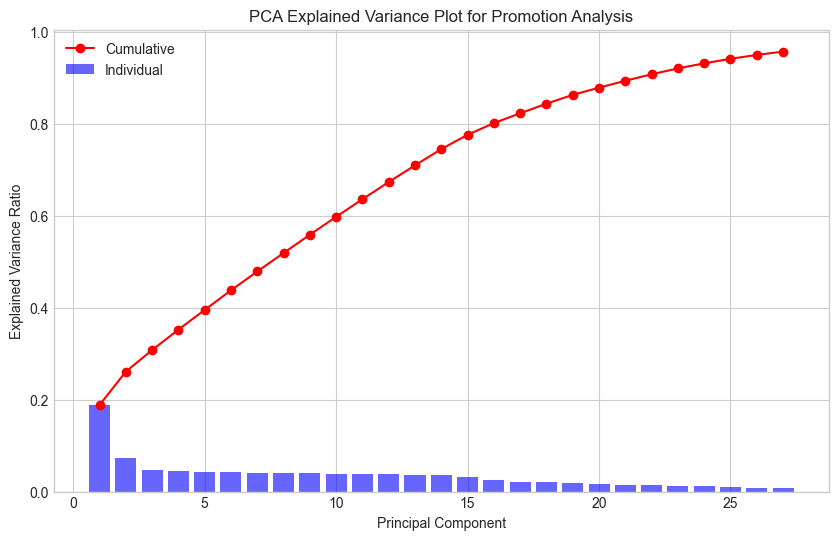

Number of PCA components: 27
Total explained variance: 0.9573


In [9]:
# Explained variance plot for PCA
try:
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance_ratio)
    plt.figure(figsize=(10, 6))
    plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.6, color='b', label='Individual')
    plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance, marker='o', color='r', label='Cumulative')
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    plt.title('PCA Explained Variance Plot for Promotion Analysis')
    plt.legend()
    plt.grid(True)
    plt.show()
    print(f"Number of PCA components: {X_pca.shape[1]}")
    print(f"Total explained variance: {cumulative_variance[-1]:.4f}")
except Exception as e:
    print(f"Error plotting PCA variance: {e}")
    raise

In [10]:
# Train-test split (stratify for balance)
try:
    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42, stratify=y)
    print("X_train shape (after PCA):", X_train.shape)
    print("X_test shape (after PCA):", X_test.shape)
except Exception as e:
    print(f"Error in train-test split: {e}")
    raise

X_train shape (after PCA): (1029, 27)
X_test shape (after PCA): (441, 27)


In [11]:
# Apply SMOTE to balance training data
smote = SMOTE(random_state=42)
try:
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
    print("X_train_smote shape after SMOTE:", X_train_smote.shape)
    print(f"Balanced class distribution:\n{pd.Series(y_train_smote).value_counts()}")
except Exception as e:
    print(f"Error in SMOTE: {e}")
    raise

X_train_smote shape after SMOTE: (1244, 27)
Balanced class distribution:
YearsSinceLastPromotion
1    622
0    622
Name: count, dtype: int64


In [12]:
# Define function to fit ML algorithms with CV and additional metrics
def fit_ml_algo(algo, X_train, y_train, X_test, y_test, cv):
    try:
        model = algo.fit(X_train, y_train)
        acc = round(model.score(X_train, y_train) * 100, 2)
        acc_cv = round(cross_val_score(algo, X_train, y_train, cv=cv, scoring='accuracy').mean() * 100, 2)
        train_pred = model.predict(X_train)
        test_pred = model.predict(X_test)
        test_acc = round(metrics.accuracy_score(y_test, test_pred) * 100, 2)
        report = classification_report(y_test, test_pred, output_dict=True)
        precision_1 = round(report['1']['precision'], 2)
        recall_1 = round(report['1']['recall'], 2)
        f1_1 = round(report['1']['f1-score'], 2)
        auc_roc = None
        if hasattr(model, 'predict_proba'):
            y_prob = model.predict_proba(X_test)[:, 1]
            auc_roc = round(auc(*roc_curve(y_test, y_prob)[:2]), 2)
        return model, train_pred, acc, acc_cv, test_pred, test_acc, precision_1, recall_1, f1_1, auc_roc
    except Exception as e:
        print(f"Error in fit_ml_algo for {algo}: {e}")
        raise

In [13]:
# Hyperparameter tuning for Random Forest
rf_param_grid = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]}
try:
    rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=5)
    rf_grid.fit(X_train_smote, y_train_smote)
    best_rf = rf_grid.best_estimator_
    print("Best Random Forest params:", rf_grid.best_params_)
except Exception as e:
    print(f"Error in Random Forest tuning: {e}")
    raise

Best Random Forest params: {'max_depth': 20, 'n_estimators': 100}


In [14]:
# Train and save Random Forest model
print("Training Random Forest for promotion prediction...")
start_time = time.time()
try:
    model, train_pred, acc, acc_cv, test_pred, test_acc, prec_1, rec_1, f1_1, auc_roc = fit_ml_algo(
        best_rf, X_train_smote, y_train_smote, X_test, y_test, 10
    )
    runtime = time.time() - start_time
    print("Random Forest Results:")
    print(f"Train Accuracy: {acc}%")
    print(f"CV 10-Fold Accuracy: {acc_cv}%")
    print(f"Test Accuracy: {test_acc}%")
    print(f"AUC-ROC: {auc_roc if auc_roc else 'N/A'}")
    print("Classification Report:\n", classification_report(y_test, test_pred))
    print(f"Running Time: {datetime.timedelta(seconds=runtime)}")

    # Save model
    joblib.dump(model, 'model_random_forest_promotion.pkl')
    print("Random Forest model saved as 'model_random_forest_promotion.pkl'")
except Exception as e:
    print(f"Error training Random Forest: {e}")
    raise

Training Random Forest for promotion prediction...
Random Forest Results:
Train Accuracy: 100.0%
CV 10-Fold Accuracy: 83.28%
Test Accuracy: 77.32%
AUC-ROC: 0.88
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.81      0.81       267
           1       0.71      0.71      0.71       174

    accuracy                           0.77       441
   macro avg       0.76      0.76      0.76       441
weighted avg       0.77      0.77      0.77       441

Running Time: 0:00:09.625960
Random Forest model saved as 'model_random_forest_promotion.pkl'


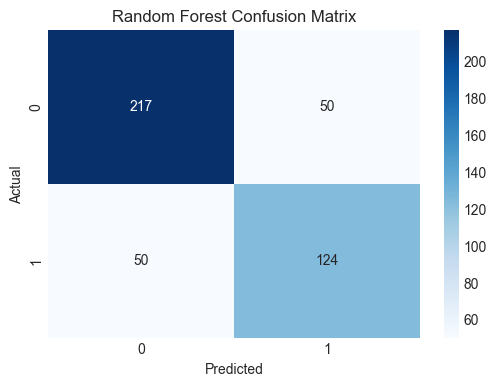

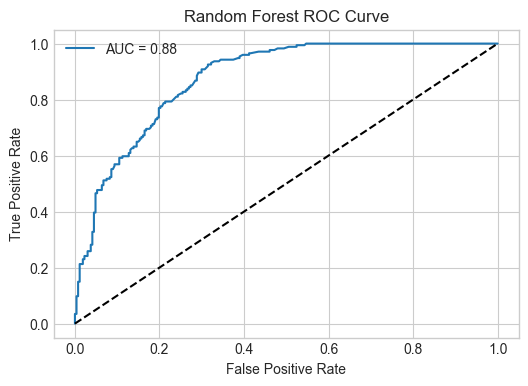

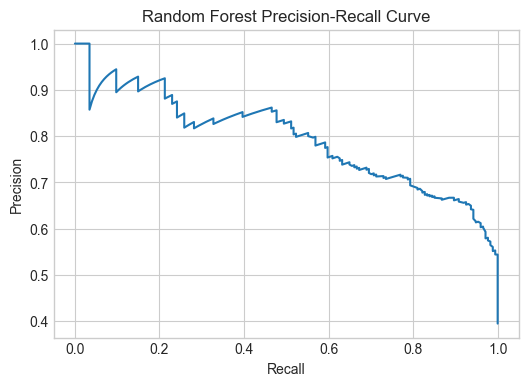

In [15]:
# Visuals for Random Forest
try:
    # Confusion Matrix
    cm = confusion_matrix(y_test, test_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Random Forest Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # ROC Curve
    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f'AUC = {auc_roc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Random Forest ROC Curve')
    plt.legend()
    plt.show()

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    plt.figure(figsize=(6, 4))
    plt.plot(recall, precision)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Random Forest Precision-Recall Curve')
    plt.show()
except Exception as e:
    print(f"Error plotting visuals: {e}")
    raise

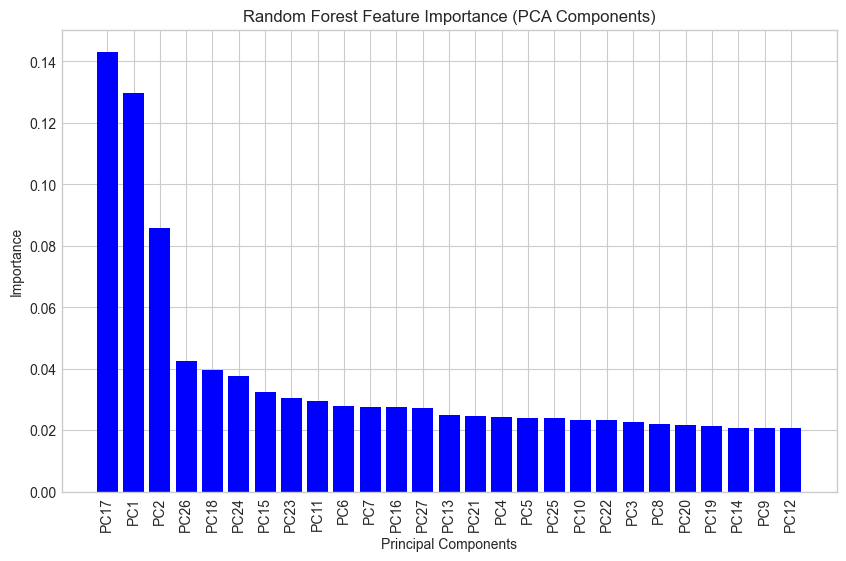

In [16]:
# Feature Importance for Random Forest
try:
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(importances)), importances[indices], color='b')
    plt.xticks(range(len(importances)), [f'PC{i+1}' for i in indices], rotation=90)
    plt.title('Random Forest Feature Importance (PCA Components)')
    plt.xlabel('Principal Components')
    plt.ylabel('Importance')
    plt.show()
except Exception as e:
    print(f"Error plotting feature importance: {e}")
    raise

In [17]:
# Save preprocessed data
try:
    np.save('X_pca_promotion.npy', X_pca)
    np.save('X_train_smote_promotion.npy', X_train_smote)
    np.save('y_train_smote_promotion.npy', y_train_smote)
    np.save('X_test_promotion.npy', X_test)
    np.save('y_test_promotion.npy', y_test)
    print("Preprocessed data saved as .npy files for promotion analysis")
except Exception as e:
    print(f"Error saving preprocessed data: {e}")
    raise

# Verify saved files
print("Files in current directory:")
for file in os.listdir('.'):
    if file.endswith(('.pkl', '.npy', '.html')):
        print(f"✓ {file}")

Preprocessed data saved as .npy files for promotion analysis
Files in current directory:
✓ attrition_report.html
✓ model_decision_tree.pkl
✓ model_gradient_boosting.pkl
✓ model_knn.pkl
✓ model_linear_svc.pkl
✓ model_logistic_regression.pkl
✓ model_random_forest.pkl
✓ model_random_forest_promotion.pkl
✓ model_xgboost.pkl
✓ pca.pkl
✓ preprocessor.pkl
✓ promotion_report.html
✓ X_pca.npy
✓ X_pca_promotion.npy
✓ X_test.npy
✓ X_test_promotion.npy
✓ X_train_smote.npy
✓ X_train_smote_promotion.npy
✓ y_test.npy
✓ y_test_promotion.npy
✓ y_train_smote.npy
✓ y_train_smote_promotion.npy


# Notes:
# - Target: Binary classification for recent promotion (YearsSinceLastPromotion == 0).
# - Uses Random Forest with hyperparameter tuning for consistency with attrition notebook.
# - Loads preprocessor and PCA from 'preprocessor.pkl' and 'pca.pkl' if available, else recreates them.
# - PCA applied before dropping target-related columns to ensure compatibility with pca.pkl (49 features).
# - Saves 'model_random_forest_promotion.pkl' for use in chatbot/Streamlit app.
# - Visuals: Confusion matrix, ROC curve, Precision-Recall curve, and feature importance.
# - Run after 'employee_attrition_prediction_enhanced.ipynb' to ensure preprocessor/pca compatibility.
# - Outputs: Model, preprocessed data (.npy), and profiling report (.html).